* __Задание 0__: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

* __Задание 1__: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

* __Задание 2__: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

* __Задание 3__: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

* __Задание 4__: преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

* __Задание 5__: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

* __Задание 6__: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

* __Задание 7__: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

In [157]:
import os
from copy import deepcopy
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
import datetime
from typing import List, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [151]:
train = pd.read_csv("assignment_train.csv")
test = pd.read_csv("assignment_test.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
train.shape

(50001, 394)

In [3]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")


In [96]:
to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]

categorical = train.select_dtypes(include=["object"]).columns.tolist()

In [97]:
categorical

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [18]:
def extract_date_feauters(data):
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['dayofmonth'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['hour'] = data['date'].dt.hour
    return data

In [64]:
def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

In [ ]:
def fit_pca(X, to_drop):
    scaler = StandardScaler(with_mean=False)

    numerical = train.select_dtypes(exclude=["object"]).columns
    x = X[numerical]
    to_drop = set(x.columns) & set(to_drop)
    if to_drop:
        x=x.drop(to_drop, axis=1)
    numerical = x.select_dtypes(exclude=["object"]).columns
    x.fillna(0, inplace=True)

x_train, x_valid = train_test_split(x, train_size=0.6, random_state=27, shuffle=True)
y_train, y_valid = train_test_split(train["isFraud"], train_size=0.6, random_state=27, shuffle=True)

x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=72, shuffle=True)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=72, shuffle=True)

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=numerical)
x_valid_scaled = pd.DataFrame(scaler.transform(x_valid), columns=numerical)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=numerical)

In [126]:
def prepare_data(X, categorical, to_drop, param=0):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.
    
    param: номер задания

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    
    if param==1:  
        X_transformed['date'] = [datetime.datetime(2017, 12, 1, 0, 0, 0) + datetime.timedelta(seconds=s) for s in X_transformed.TransactionDT]
        X_transformed = extract_date_feauters(X_transformed)
        X_transformed = X_transformed.drop('date', axis=1)
    
    elif param==2:
        stats = create_categorical_aggs(X_transformed, groupby_id="card4", features=["TransactionAmt"], prefix="card4")
        X_transformed = pd.merge(X_transformed, stats, on='card4', how='inner')
        X_transformed["DELTA_TransactionAmt_CARD4_TRANSACTIONAMT_RATIO"] = X_transformed["TransactionAmt"] - X_transformed["CARD4_TRANSACTIONAMT_RATIO"]
        X_transformed["TOTAL_TransactionAmt_CARD4_TRANSACTIONAMT_RATIO"] = X_transformed["TransactionAmt"] / X_transformed["CARD4_TRANSACTIONAMT_RATIO"]
        
        stats = create_categorical_aggs(X_transformed, groupby_id="card6", features=["TransactionAmt"], prefix="card6")
        X_transformed = pd.merge(X_transformed, stats, on='card6', how='inner')
        X_transformed["DELTA_TransactionAmt_CARD6_TRANSACTIONAMT_RATIO"] = X_transformed["TransactionAmt"] - X_transformed["CARD6_TRANSACTIONAMT_RATIO"]
        X_transformed["TOTAL_TransactionAmt_CARD6_TRANSACTIONAMT_RATIO"] = X_transformed["TransactionAmt"] / X_transformed["CARD6_TRANSACTIONAMT_RATIO"]

    elif param==3:
        stats = X_transformed.groupby(["card4"])["isFraud"].size().reset_index(name='card4_counts')
        X_transformed = pd.merge(X_transformed, stats, on='card4', how='left')
        
        stats = X_transformed.groupby(["card6"])["isFraud"].size().reset_index(name='card6_counts')
        X_transformed = pd.merge(X_transformed, stats, on='card6', how='left')
        
    elif param==4:
        X_transformed["TransactionAmt_Log"] = np.log(X_transformed["TransactionAmt"])
        a = np.modf(X_transformed["TransactionAmt_Log"])
        X_transformed["TransactionAmt_Log_frac"] = a[0]
        X_transformed["TransactionAmt_Log_int"] = a[1]
        
        
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    
    return X_transformed

In [102]:
def ExecuteTask(train, test, number=0):
    
    """
    Выполняем задание.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Трейн.

    test: pandas.core.frame.DataFrame
        Тест.
    
    param: номер задания
    
    """
    
    x_train, x_valid = train_test_split(train, train_size=0.6, random_state=27, shuffle=True)
    y_train, y_valid = train_test_split(train["isFraud"], train_size=0.6, random_state=27, shuffle=True)

    x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=72, shuffle=True)
    y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=72, shuffle=True)
    
        
    x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop, param=number)
    x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop, param=number)
    x_test = prepare_data(x_test, categorical=categorical, to_drop=to_drop, param=number)
    x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop, param=number)
    
    cb_params_1000 = {
        "n_estimators": 1000,
        "learning_rate": 0.01,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "max_bin": 20,
        "verbose": 10,
        "max_depth": 6,
        "l2_leaf_reg": 100,
        "early_stopping_rounds": 50,
        "thread_count": 6,
        "random_seed": 27
    }
    
    model = fit_catboost(x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)
    
    evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])
    

In [25]:
ExecuteTask(train, test, 0)

0:	test: 0.6329804	best: 0.6329804 (0)	total: 183ms	remaining: 3m 2s
10:	test: 0.7618445	best: 0.7653676 (8)	total: 1.74s	remaining: 2m 36s
20:	test: 0.7930679	best: 0.7930679 (20)	total: 3.28s	remaining: 2m 32s
30:	test: 0.7928800	best: 0.7962874 (24)	total: 4.74s	remaining: 2m 28s
40:	test: 0.8037710	best: 0.8040604 (32)	total: 6.32s	remaining: 2m 27s
50:	test: 0.8181301	best: 0.8181301 (50)	total: 7.9s	remaining: 2m 27s
60:	test: 0.8192070	best: 0.8192070 (60)	total: 9.49s	remaining: 2m 26s
70:	test: 0.8255115	best: 0.8259605 (69)	total: 11.1s	remaining: 2m 24s
80:	test: 0.8265871	best: 0.8265871 (80)	total: 12.6s	remaining: 2m 23s
90:	test: 0.8286209	best: 0.8286209 (90)	total: 14.2s	remaining: 2m 21s
100:	test: 0.8336715	best: 0.8336715 (100)	total: 15.8s	remaining: 2m 20s
110:	test: 0.8369921	best: 0.8369921 (110)	total: 17.4s	remaining: 2m 18s
120:	test: 0.8414312	best: 0.8414312 (120)	total: 18.9s	remaining: 2m 17s
130:	test: 0.8452370	best: 0.8452370 (130)	total: 20.5s	remaini

In [51]:
ExecuteTask(train, test, 1)

0:	test: 0.6485707	best: 0.6485707 (0)	total: 182ms	remaining: 3m 2s
10:	test: 0.7827775	best: 0.7827775 (10)	total: 1.85s	remaining: 2m 46s
20:	test: 0.8030880	best: 0.8032186 (18)	total: 3.32s	remaining: 2m 34s
30:	test: 0.8134770	best: 0.8134770 (30)	total: 4.79s	remaining: 2m 29s
40:	test: 0.8163637	best: 0.8166673 (38)	total: 6.35s	remaining: 2m 28s
50:	test: 0.8204018	best: 0.8205203 (49)	total: 7.86s	remaining: 2m 26s
60:	test: 0.8203998	best: 0.8207873 (52)	total: 9.36s	remaining: 2m 24s
70:	test: 0.8228372	best: 0.8229957 (66)	total: 10.9s	remaining: 2m 22s
80:	test: 0.8312177	best: 0.8312177 (80)	total: 12.4s	remaining: 2m 20s
90:	test: 0.8349627	best: 0.8349627 (90)	total: 13.9s	remaining: 2m 18s
100:	test: 0.8403928	best: 0.8403928 (100)	total: 15.4s	remaining: 2m 17s
110:	test: 0.8460457	best: 0.8460457 (110)	total: 17s	remaining: 2m 15s
120:	test: 0.8471919	best: 0.8477113 (115)	total: 18.5s	remaining: 2m 14s
130:	test: 0.8511192	best: 0.8511192 (130)	total: 20s	remaining

Вывод: качество изменилось незначительно. Можно было и не делать такое преобразование.

In [56]:
train.columns.to_list()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [60]:
train['card4'].value_counts()

visa                32562
mastercard          15696
american express     1083
discover              654
Name: card4, dtype: int64

In [61]:
train['card6'].value_counts()

debit              34206
credit             15786
debit or credit        3
charge card            3
Name: card6, dtype: int64

In [69]:
stats = create_categorical_aggs(
    train, groupby_id="card4", features=["TransactionAmt"], prefix="card4_"
)
stats.head()

,card4,CARD4_TRANSACTIONAMT_RATIO,CARD4_TRANSACTIONAMT_TOTAL
0,american express,167.022392,1.808852e+05
1,discover,211.559924,1.383602e+05
2,mastercard,124.734717,1.957836e+06
3,visa,126.812814,4.129279e+06


In [71]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V334,V335,V336,V337,V338,V339,CARD4_TRANSACTIONAMT_RATIO,CARD4_TRANSACTIONAMT_TOTAL,DELTA_TransactionAmt_CARD4_TRANSACTIONAMT_RATIO,TOTAL_TransactionAmt_CARD4_TRANSACTIONAMT_RATIO
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,211.559924,138360.19,-143.059924,0.323785
1,2987135,0,88671,3000.0,W,2616,NaN,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,211.559924,138360.19,2788.440076,14.180379
2,2987223,0,89948,54.0,W,2616,NaN,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,211.559924,138360.19,-157.559924,0.255247
3,2987360,0,92221,226.0,W,2616,NaN,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,211.559924,138360.19,14.440076,1.068255
4,2987451,0,93931,59.0,W,6344,327.0,150.0,discover,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,211.559924,138360.19,-152.559924,0.278881


In [73]:
ExecuteTask(train, test, 2)

0:	test: 0.6329804	best: 0.6329804 (0)	total: 176ms	remaining: 2m 55s
10:	test: 0.7618445	best: 0.7653676 (8)	total: 1.69s	remaining: 2m 32s
20:	test: 0.7930679	best: 0.7930679 (20)	total: 3.19s	remaining: 2m 28s
30:	test: 0.7928800	best: 0.7962874 (24)	total: 4.64s	remaining: 2m 25s
40:	test: 0.8037710	best: 0.8040604 (32)	total: 6.15s	remaining: 2m 23s
50:	test: 0.8181301	best: 0.8181301 (50)	total: 7.67s	remaining: 2m 22s
60:	test: 0.8192070	best: 0.8192070 (60)	total: 9.19s	remaining: 2m 21s
70:	test: 0.8255115	best: 0.8259605 (69)	total: 10.7s	remaining: 2m 20s
80:	test: 0.8265871	best: 0.8265871 (80)	total: 12.2s	remaining: 2m 18s
90:	test: 0.8286209	best: 0.8286209 (90)	total: 13.8s	remaining: 2m 17s
100:	test: 0.8336715	best: 0.8336715 (100)	total: 15.3s	remaining: 2m 16s
110:	test: 0.8369921	best: 0.8369921 (110)	total: 16.8s	remaining: 2m 14s
120:	test: 0.8414312	best: 0.8414312 (120)	total: 18.3s	remaining: 2m 13s
130:	test: 0.8452370	best: 0.8452370 (130)	total: 19.9s	remai

Вывод: снова ничего не поменялось...

Text(0, 0.5, 'target-card6')

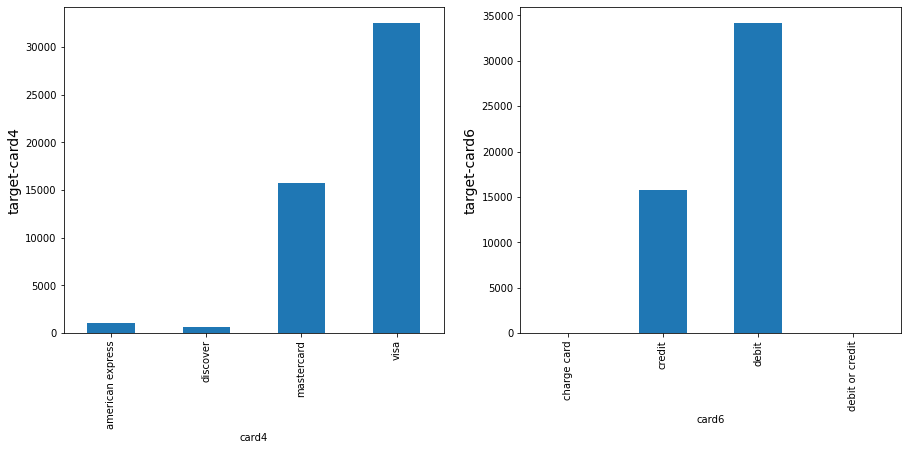

In [78]:
#Самый простой способ получить количество строк на группу - это вызвать .size(), который возвращает Series:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["card4"])["isFraud"].size().plot(kind="bar", ax=axes[0])
train.groupby(["card6"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-card4", fontsize=14)
axes[1].set_ylabel("target-card6", fontsize=14)

In [113]:
ExecuteTask(train, test, 3)

0:	test: 0.6319998	best: 0.6319998 (0)	total: 167ms	remaining: 2m 47s
10:	test: 0.7937530	best: 0.7937530 (10)	total: 1.87s	remaining: 2m 47s
20:	test: 0.8142183	best: 0.8147589 (19)	total: 3.57s	remaining: 2m 46s
30:	test: 0.8155002	best: 0.8175976 (28)	total: 5.63s	remaining: 2m 55s
40:	test: 0.8174287	best: 0.8190507 (33)	total: 7.21s	remaining: 2m 48s
50:	test: 0.8171250	best: 0.8190507 (33)	total: 8.74s	remaining: 2m 42s
60:	test: 0.8175855	best: 0.8201263 (56)	total: 10.2s	remaining: 2m 37s
70:	test: 0.8173866	best: 0.8201263 (56)	total: 11.8s	remaining: 2m 34s
80:	test: 0.8195341	best: 0.8201263 (56)	total: 13.4s	remaining: 2m 31s
90:	test: 0.8216193	best: 0.8218016 (89)	total: 14.9s	remaining: 2m 28s
100:	test: 0.8241276	best: 0.8241276 (100)	total: 16.6s	remaining: 2m 27s
110:	test: 0.8313277	best: 0.8313277 (110)	total: 18.2s	remaining: 2m 25s
120:	test: 0.8376518	best: 0.8376518 (120)	total: 20s	remaining: 2m 25s
130:	test: 0.8408016	best: 0.8408016 (130)	total: 21.7s	remain

Вывод: одно и тоже, может что то делаю не так?

In [127]:
ExecuteTask(train, test, 4)

0:	test: 0.6485707	best: 0.6485707 (0)	total: 184ms	remaining: 3m 3s
10:	test: 0.7827775	best: 0.7827775 (10)	total: 1.78s	remaining: 2m 40s
20:	test: 0.8051055	best: 0.8052029 (18)	total: 3.27s	remaining: 2m 32s
30:	test: 0.8145263	best: 0.8145263 (30)	total: 4.78s	remaining: 2m 29s
40:	test: 0.8172809	best: 0.8176511 (38)	total: 6.32s	remaining: 2m 27s
50:	test: 0.8210522	best: 0.8211646 (49)	total: 7.84s	remaining: 2m 25s
60:	test: 0.8209873	best: 0.8214539 (52)	total: 9.34s	remaining: 2m 23s
70:	test: 0.8207562	best: 0.8214539 (52)	total: 10.9s	remaining: 2m 22s
80:	test: 0.8310012	best: 0.8310012 (80)	total: 12.4s	remaining: 2m 20s
90:	test: 0.8360025	best: 0.8360025 (90)	total: 14s	remaining: 2m 20s
100:	test: 0.8412509	best: 0.8412509 (100)	total: 15.7s	remaining: 2m 19s
110:	test: 0.8465066	best: 0.8465066 (110)	total: 17.3s	remaining: 2m 18s
120:	test: 0.8476599	best: 0.8480620 (115)	total: 18.8s	remaining: 2m 16s
130:	test: 0.8513283	best: 0.8513283 (130)	total: 20.4s	remaini

Вывод: тоже самое

In [169]:
#PCA
scaler = StandardScaler(with_mean=False)

numerical = train.select_dtypes(exclude=["object"]).columns
x = train[numerical]
to_drop = set(x.columns) & set(to_drop)
if to_drop:
     x=x.drop(to_drop, axis=1)
numerical = x.select_dtypes(exclude=["object"]).columns
x.fillna(0, inplace=True)

x_train, x_valid = train_test_split(x, train_size=0.6, random_state=27, shuffle=True)
y_train, y_valid = train_test_split(train["isFraud"], train_size=0.6, random_state=27, shuffle=True)

x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=72, shuffle=True)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=72, shuffle=True)

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=numerical)
x_valid_scaled = pd.DataFrame(scaler.transform(x_valid), columns=numerical)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=numerical)

x = test[numerical]
to_drop = set(x.columns) & set(to_drop)
if to_drop:
     x=x.drop(to_drop, axis=1)
numerical = x.select_dtypes(exclude=["object"]).columns
x.fillna(0, inplace=True)

x_test_lb_scaled = pd.DataFrame(scaler.transform(x), columns=numerical)

c:\users\sych_\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [170]:
x_train_scaled.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0.446989,0.360653,3.322318,14.290867,5.282919,2.185317,4.368100,0.00000,0.000000,0.006133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.095909,0.643746,2.496327,17.625403,5.282919,1.382379,3.012483,0.00000,2.722069,0.006133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.267041,2.538042,3.395739,14.290867,5.330088,1.183714,4.368100,0.04351,0.000000,0.036799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.520453,2.052681,1.376651,14.290867,5.282919,1.018159,4.368100,0.00000,0.000000,0.006133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.161285,1.857353,0.000000,14.290867,5.330088,1.696932,4.368100,0.00000,0.000000,0.006133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
pca = PCA(random_state=100)
pca.fit(x_train_scaled)
len(pca.explained_variance_ratio_)

377

In [165]:
pca.explained_variance_ratio_[:100].sum()

0.9578028716190597

Выходит, если оставить 100 главных компонент с самой большой объяснённой дисперсией, то мы сохраним почти 96 процентов информации.

In [171]:
pca = PCA(n_components=100, random_state=100)

x_train_mc = pca.fit_transform(x_train_scaled)
x_valid_mc = pca.transform(x_valid_scaled)
x_test_mc = pca.transform(x_test_scaled)
x_test_lb_mc = pca.transform(x_test_lb_scaled)

In [180]:
x_train_mc.shape[1]

100

In [182]:
df = pd. DataFrame(data=x_train_mc, columns=["col_"+str(x+1) for x in range(x_train_mc.shape[1])]) 
df.head()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100
0,-3.519697,0.272822,-0.309705,-0.704113,0.584743,0.264029,-0.272884,-0.433989,1.493615,0.093515,...,0.113867,-0.039609,0.130621,0.119670,-0.253019,-0.046313,0.145473,0.146431,0.086257,-0.034448
1,9.475159,14.820549,-3.518725,-2.358673,2.838323,0.760122,2.143355,-0.846703,3.770278,-1.346067,...,0.372106,-0.172536,0.310298,0.614190,-0.114346,0.302977,-0.013129,0.265953,-0.201599,0.262131
2,-7.164495,0.698474,1.445910,-0.797077,-0.681494,2.979298,1.578646,0.649074,-2.709818,0.375542,...,0.381845,0.632193,-0.379008,0.564148,-0.598684,-0.514132,-0.744180,-0.080997,-0.006511,0.063437
3,-4.343345,0.310251,0.067840,-0.743517,0.315871,1.187591,0.076548,-0.316830,0.449590,0.143466,...,-0.325910,0.718134,0.039961,0.293794,-0.276590,-0.328476,-0.036173,0.155034,0.096943,0.014528
4,-2.944730,-2.757378,-0.571746,-0.481081,0.622057,-0.334765,-1.363467,-0.682066,1.778438,0.315574,...,-0.158475,-0.149896,-0.445415,0.043119,0.005762,-0.305612,0.052153,0.332462,0.200579,0.065879
